In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
from skimage import exposure
from skimage import filters
from scipy import ndimage
import scipy.io

import pims
import trackpy as tp

from os import path

from tqdm import tqdm


In [2]:

base_path = path.join("I:","alex_ultasound","monday_22_02_2021","ss316_bench")

bench_mark_file_list = ['ss316_bench_3_m.cine',
                       'ss316_bench_4_m.cine',
                       'ss316_bench_5_m.cine',
                       'ss316_bench_6_m.cine']

bench_mark = [pims.open(path.join(base_path, f_name)) for f_name in bench_mark_file_list]

In [3]:
min_frame = np.Inf

for vid in bench_mark:
    if(len(vid) < min_frame):
        min_frame = len(vid)
        
min_frame

26001

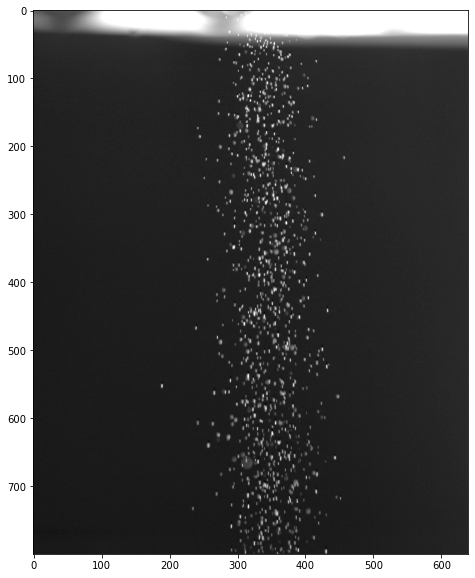

In [4]:
fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(bench_mark[0][0], cmap = 'gray')
plt.show()

In [5]:
sampled_frame = np.arange(0, min_frame-100, 5)

In [6]:
@pims.pipeline
def crop_top(image):
    return image[70:,:]

test_bench = crop_top(bench_mark[0])

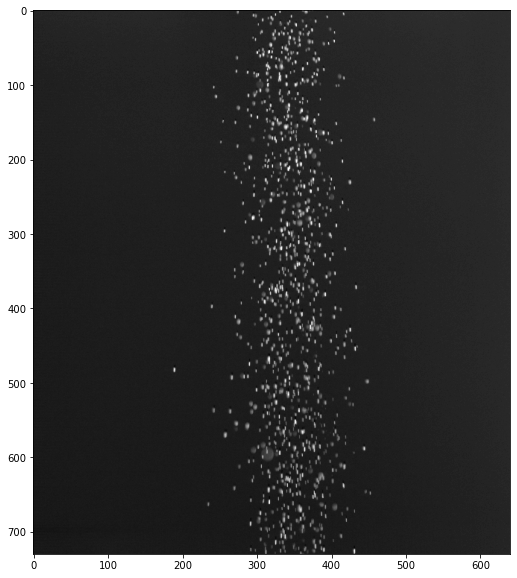

In [7]:
fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(test_bench[0], cmap = 'gray')
plt.show()

In [8]:
@pims.pipeline
def binarise_half_way(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return ((min_val+(max_val-min_val)*0.30) <= image).astype(int)

binary_vid_bench_alt = binarise_half_way(test_bench)

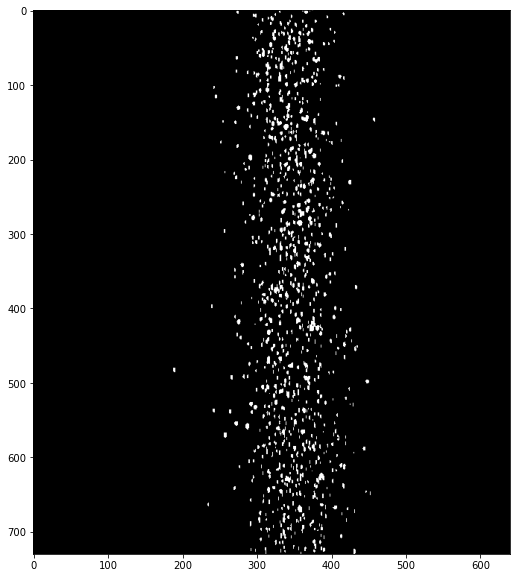

In [9]:
fig, axs = plt.subplots( figsize = (10,10))
axs.imshow(binary_vid_bench_alt[0],cmap = 'gray')
plt.show()

In [10]:
from skimage import measure
from skimage import morphology
import pandas as pd

@pims.pipeline
def avg_pix_area(image):
    labeled_im = morphology.label(image, connectivity = 1)
    region_props = measure.regionprops(labeled_im)
    area_list = [reg.area for reg in region_props]
    return (np.mean(area_list),np.std(area_list))

@pims.pipeline
def full_pix_area(image):
    labeled_im = morphology.label(image, connectivity = 1)
    region_props = measure.regionprops(labeled_im)
    area_list = [reg.area for reg in region_props]
    return area_list

In [11]:
import time

start = time.process_time() 
def compute_avg_blob_size(im_list, sampled_frame):
    
    df_half = pd.DataFrame(columns=["file","frame",'particle_area'])
    
    pbar = tqdm(total=len(im_list)*len(sampled_frame))
    for i, b_im in enumerate(im_list):
        cropped_im = crop_top(b_im)
        binary_vid_half = binarise_half_way(cropped_im)

        for f in sampled_frame:
            full_blob = full_pix_area(binary_vid_half)[f]
            n_blob = len(full_blob)
            if n_blob > 0:
                data = np.stack(([i]*n_blob, [f]*n_blob, full_blob), axis = 1).astype(float)

                df_add = pd.DataFrame(data, columns = ["file","frame",'particle_area'])

                df_half = df_half.append(df_add, ignore_index = True)
            pbar.update(1)
    
    pbar.close()
    return df_half


data_bench = compute_avg_blob_size(bench_mark,sampled_frame)

end = time.process_time() 

print('processing time: {}'.format(end-start))

100%|████████████████████████████████████████████████████████████████████████████| 20724/20724 [34:16<00:00, 10.08it/s]

processing time: 1756.859375


In [12]:
data_bench.to_csv('./data/blob_half_bench_ss_30.csv')

In [13]:
data_half_mean_bench = data_bench.groupby(['file']).mean().drop(columns=['frame'])

In [14]:
data_half_mean_bench.to_csv('./data/blob_half_bench_mean_ss_30.csv')